In [1]:
import keras 

In [2]:
from keras.datasets import imdb
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

# Load imdb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3)
vocab = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

# Split the train set into train and validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=17)

# Training batch size
batch_size = 50

# Put x into tensors
x_train = [torch.tensor(x) for x in x_train]
# Add zeros at the end of each word vector to create vectors with equal size
X_train = nn.utils.rnn.pad_sequence(x_train, batch_first=True, padding_value=0).long()
# Split the data into batches
X_train = X_train.view(-1, batch_size, X_train.shape[1])

# Apply the same length of X_train on X_val and X_test
len_voc = int((X_train.max()+1).item())

x_val = [torch.tensor(x) for x in x_val]
X_val = nn.utils.rnn.pad_sequence(x_val, batch_first=True, padding_value=0).long()
X_val = X_val.view(-1, batch_size, X_val.shape[1])

x_test = [torch.tensor(x) for x in x_test]
X_test = nn.utils.rnn.pad_sequence(x_test, batch_first=True, padding_value=0,).long()
X_test  = X_test.view(-1, batch_size, X_test.shape[1])

y_train = torch.tensor(y_train).view(-1, batch_size)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Create word embedding from scratch
embeddings = nn.Embedding(len_voc, 100)

# Build CNN model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embeddings = nn.Embedding(len_voc, 100)
        self.cnn = nn.Conv2d(1, 100, (3, 100))
        self.clf = nn.Linear(100, 2)

    def forward(self, x):
        # Add word embeddings
        x = self.embeddings(x)
        # Add an extra dimension for CNN
        x = x.unsqueeze(1)
        # Apply CNN
        x = self.cnn(x)
        # Choose the maximum value of each filter and delete the extra dimension
        x = x.max(2)[0].squeeze(2)
        # Choose the most important features for the classification
        x = F.relu(x) 
        #  Apply linear nn for classification
        x = self.clf(x)
        # Return the probability of positive and negative
        return F.softmax(x, 1)

# Use GPU for the model      
model = Model().cuda()
# opmization function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# calculate the loss
criterio  = nn.CrossEntropyLoss()


In [4]:
from sklearn import metrics

# Function for evaluating
def get_f1(X, y_real):
  y_pred = []
  for x in X:
      # Choose the value with higher probability
      y_pred.append(model(x.cuda()).argmax(1).cpu().detach())
  y_pred = torch.cat(y_pred)
  return metrics.f1_score(y_true=y_real, y_pred=y_pred)

# Training steps
epochs = 20
LOSS = []
for e in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        
        # Delete the prvious values of the gradient
        optimizer.zero_grad()
        x, y = x.cuda(), y.cuda()
        
        y_pred = model(x)
        loss = criterio(y_pred, y)

        # Compute the gradient
        loss.backward()

        # Apply the optimization method for one step
        optimizer.step()
        
        LOSS.append(loss.item())
        if i%200==0:
            with torch.no_grad():
                f1 = get_f1(X_val, y_val)
            print('Epoch: %d \t Batch: %d \t Loss: %.10f \t F1_val: %.10f'%(e,i, torch.tensor(LOSS[-100:]).mean(), f1))


Epoch: 0 	 Batch: 0 	 Loss: 0.7217202783 	 F1_val: 0.2373188406
Epoch: 0 	 Batch: 200 	 Loss: 0.5756949186 	 F1_val: 0.7776928953
Epoch: 1 	 Batch: 0 	 Loss: 0.5172477365 	 F1_val: 0.8181099249
Epoch: 1 	 Batch: 200 	 Loss: 0.4657655358 	 F1_val: 0.8353818255
Epoch: 2 	 Batch: 0 	 Loss: 0.4471399188 	 F1_val: 0.8496240602
Epoch: 2 	 Batch: 200 	 Loss: 0.4136322737 	 F1_val: 0.8605797673
Epoch: 3 	 Batch: 0 	 Loss: 0.4016897678 	 F1_val: 0.8643768400
Epoch: 3 	 Batch: 200 	 Loss: 0.3766904473 	 F1_val: 0.8653693407
Epoch: 4 	 Batch: 0 	 Loss: 0.3708881438 	 F1_val: 0.8699943063
Epoch: 4 	 Batch: 200 	 Loss: 0.3563393652 	 F1_val: 0.8701941378
Epoch: 5 	 Batch: 0 	 Loss: 0.3519413471 	 F1_val: 0.8733810168
Epoch: 5 	 Batch: 200 	 Loss: 0.3461069465 	 F1_val: 0.8346456693
Epoch: 6 	 Batch: 0 	 Loss: 0.3439921141 	 F1_val: 0.8599498328
Epoch: 6 	 Batch: 200 	 Loss: 0.3371107578 	 F1_val: 0.7864327485
Epoch: 7 	 Batch: 0 	 Loss: 0.3350907266 	 F1_val: 0.8722947943
Epoch: 7 	 Batch: 200 	 Lo

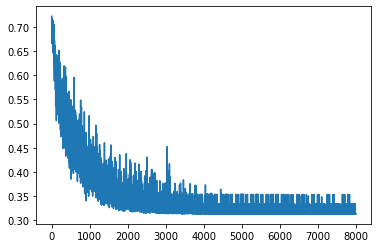

In [5]:
import matplotlib.pyplot as plt
plt.plot(LOSS)

In [6]:
print("F1_test: %.5f"%(get_f1(X_test, y_test)))


F1_test: 0.87657
